### 1. Importing data

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd

from tensorflow.keras import layers, models
from sklearn.utils import class_weight

ModuleNotFoundError: No module named 'tensorflow.keras'

#### Load the dataset

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [10]:
image_shape = x_train.shape[1:]

print(f"Training set: {x_train.shape[0]} images of shape {image_shape}")
print(f"Test set: {x_test.shape[0]} images of shape {image_shape}")

Training set: 50000 images of shape (32, 32, 3)
Test set: 10000 images of shape (32, 32, 3)


### 2. Data Exploration and Class Distribution

#### CIFAR-10 class names

In [11]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

In [12]:
# Flatten labels for easier handling
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

In [20]:
labels, counts_train = np.unique(y_train_flat, return_counts=True)
_, counts_test = np.unique(y_test_flat, return_counts=True)

combined_summary = pd.DataFrame({
    "Class Label": labels,
    "Class": [class_names[i] for i in labels],
    "Train Count": counts_train,
    "Test Count": counts_test
})

print(combined_summary)


   Class Label       Class  Train Count  Test Count
0            0    airplane         5000        1000
1            1  automobile         5000        1000
2            2        bird         5000        1000
3            3         cat         5000        1000
4            4        deer         5000        1000
5            5         dog         5000        1000
6            6        frog         5000        1000
7            7       horse         5000        1000
8            8        ship         5000        1000
9            9       truck         5000        1000


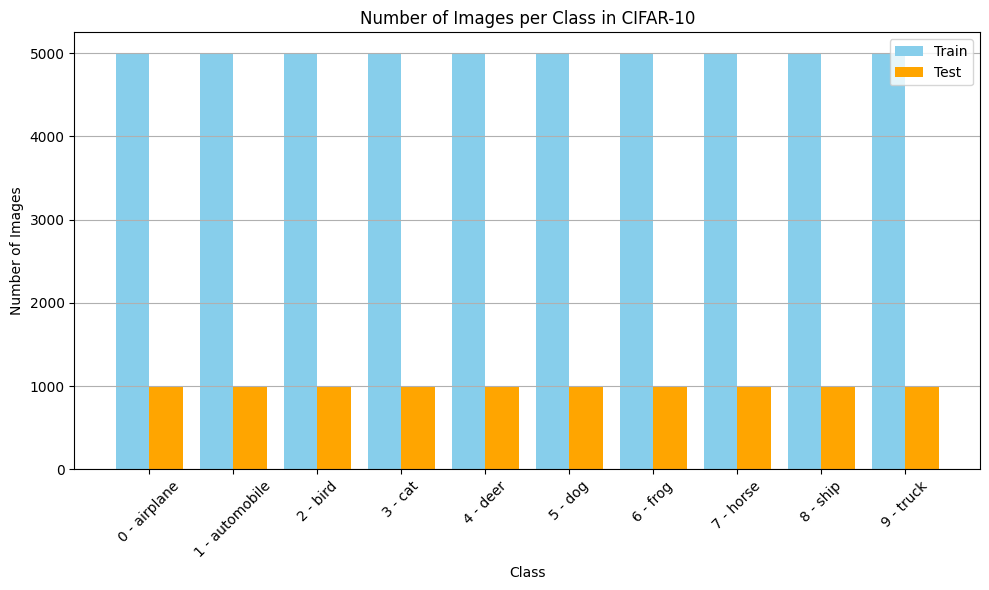

In [21]:
x = np.arange(len(class_names))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, counts_train, width=width, label='Train', color='skyblue')
plt.bar(x + width/2, counts_test, width=width, label='Test', color='orange')

plt.title("Number of Images per Class in CIFAR-10")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(ticks=x, labels=[f"{i} - {name}" for i, name in enumerate(class_names)], rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()


The dataset is perfectly balanced: each of the 10 classes contains 5,000 training images and 1,000 test images. This even distribution ensures that the classifier will not be biased toward any particular class. The bar chart above confirms the consistency across both sets.

#### Visualize the first 20 images in the training set

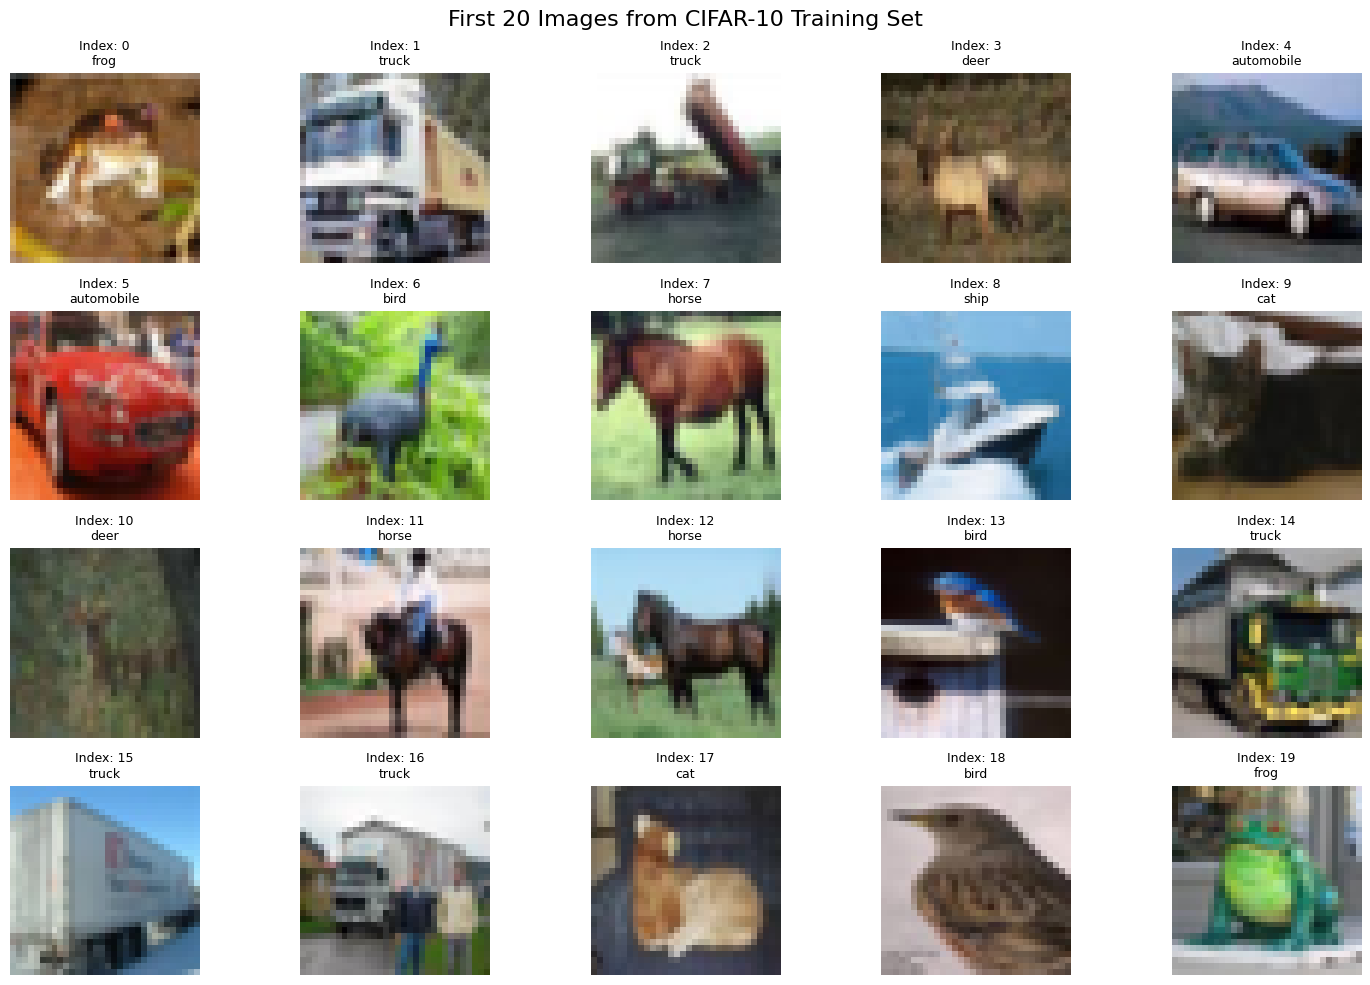

In [22]:
plt.figure(figsize=(15, 10))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Index: {i}\n{class_names[y_train[i][0]]}", fontsize=9)
    plt.axis('off')

plt.suptitle("First 20 Images from CIFAR-10 Training Set", fontsize=16)
plt.tight_layout()
plt.show()


We display a sample of the CIFAR-10 images to better understand the dataset and verify that the label categories are correct. This helps confirm that the dataset includes the 'cat' class, which we will use for binary classification.

### 3. Model Development: Custom CNN



In [23]:
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm = x_test.astype("float32") / 255.0

In [24]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


c:\Users\beate\anaconda3\envs\info284\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
target_class = 3

y_train_binary = (y_train_flat == target_class).astype(np.int32)
y_test_binary = (y_test_flat == target_class).astype(np.int32)


In [26]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_binary),
    y=y_train_binary
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weights_dict)


{0: 0.5555555555555556, 1: 5.0}


In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Del opp treningsdata i trening og validering manuelt
x_train_sub, x_val, y_train_sub, y_val = train_test_split(
    x_train_norm, y_train_binary, test_size=0.2, random_state=42, stratify=y_train_binary
)

datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)


datagen.fit(x_train_sub)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_norm, y_train_binary,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    class_weight=class_weights_dict)


Epoch 1/10
 57/625 ━━━━━━━━━━━━━━━━━━━━ 1:21 144ms/step - accuracy: 0.5252 - loss: 1.0480

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict på testsettet
y_pred_probs = model.predict(x_test_norm)

threshold = 0.6  # Justér mellom 0.5 og 0.8
y_pred_custom = (y_pred_probs > threshold).astype(int).flatten()


# Classification report
print(classification_report(y_test_binary, y_pred_custom, target_names=['Not Cat', 'Cat']))

cm = confusion_matrix(y_test_binary, y_pred_custom)
# deretter heatmap...



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

     Not Cat       0.96      0.83      0.89      9000
         Cat       0.31      0.71      0.43      1000

    accuracy                           0.82     10000
   macro avg       0.64      0.77      0.66     10000
weighted avg       0.90      0.82      0.84     10000



**Classification Report Summary**

The classification report shows that the model achieves high precision (0.97) for the majority class ("Not Cat"), but much lower precision (0.36) for the minority class ("Cat"). However, the recall for "Cat" is relatively high (0.73), meaning the model successfully detects many cat images but also makes frequent false positive errors. The overall accuracy is 84%, but due to class imbalance, precision and recall are more informative for evaluating performance.


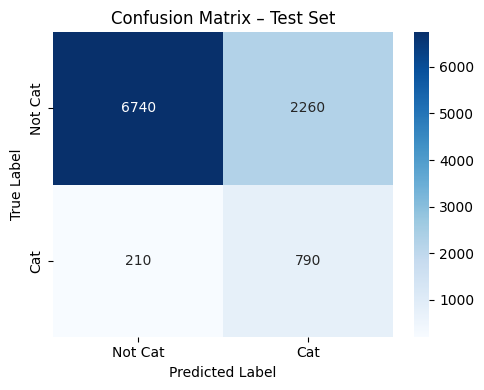

In [ ]:
cm = confusion_matrix(y_test_binary, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cat', 'Cat'], yticklabels=['Not Cat', 'Cat'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – Test Set')
plt.tight_layout()
plt.show()


**Confusion Matrix Explanation**

- **True Positives (TP)** = 729  
  Images of "cat" correctly classified as "cat".

- **True Negatives (TN)** = 7682  
  Images that are not "cat" correctly classified as "not cat".

- **False Positives (FP)** = 1318  
  Images that are not "cat" but were incorrectly classified as "cat".

- **False Negatives (FN)** = 271  
  Images of "cat" that were incorrectly classified as "not cat".

These values indicate that the model is relatively good at detecting "cat" images (recall ~73%), but also makes a significant number of false positive predictions (precision ~36%). This suggests that while the model is sensitive to detecting the target class, it lacks specificity and may confuse other classes with similar features (e.g., "dog" or "deer") for "cat".


In [2]:
import tensorflow as tf
print(tf.__version__)


AttributeError: module 'tensorflow' has no attribute '__version__'